<a href="https://colab.research.google.com/github/lgaetano/Where-is-Waldo/blob/master/Where's_Waldo_Version1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

# Retreive pretrained weights from Inception Neural Network
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Instantiate Inception with desired input shape for Where's Waldo data
pre_trained_model = InceptionV3(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Lock Inception's pre-trained layers
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

--2019-12-01 20:19:56--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   114MB/s    in 0.7s    

2019-12-01 20:19:57 (114 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# Define callback class and on_epoch_end funtion to end training when 99.9% accuracy is reached
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('acc') > 0.98):
      print('\nAccuracy is greater than 98%. Finished!')
      self.model.stop_training = True

# Instantiate Callback class
callbacks = myCallback()

In [3]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
!git clone https://github.com/lgaetano/Where-s-Waldo.git

fatal: destination path 'Where-s-Waldo' already exists and is not an empty directory.


In [5]:
%ls
%pwd
%cd /content/
%ls
%cd Where-s-Waldo/
%ls


 13_1_1.jpg    2_2_5.jpg        '6_15_1 (2).jpg'   9_0_12.jpg
 17_13_5.jpg  '3_15_1 (1).jpg'   6_15_1.jpg        9_11_9.jpg
 1_8_8.jpg     3_15_1.jpg        6_5_3.jpg         sample_data/
 1_8_9.jpg     4_2_11.jpg        9_0_10.jpg        Where-s-Waldo/
 2_1_5.jpg    '6_15_1 (1).jpg'  '9_0_12 (1).jpg'
/content
 13_1_1.jpg    2_2_5.jpg        '6_15_1 (2).jpg'   9_0_12.jpg
 17_13_5.jpg  '3_15_1 (1).jpg'   6_15_1.jpg        9_11_9.jpg
 1_8_8.jpg     3_15_1.jpg        6_5_3.jpg         sample_data/
 1_8_9.jpg     4_2_11.jpg        9_0_10.jpg        Where-s-Waldo/
 2_1_5.jpg    '6_15_1 (1).jpg'  '9_0_12 (1).jpg'
/content/Where-s-Waldo
 64.zip                       Where-s-Waldo/
 README.md                    WheresWaldo.ipynb
 Waldo_dataset_Version2.zip  "Where's_Waldo_Version1.0.ipynb"
 Waldo_dataset.zip           "Where's_Waldo_Version1.1.ipynb"


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

#local_zip = '/content/Where-s-Waldo/Waldo_dataset.zip'
local_zip = '/content/Where-s-Waldo/64.zip'
# = '/content/Where-s-Waldo/64-10TimesLessNonWaldoImages.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/Waldo_dataset'

train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')

train_waldo_dir = os.path.join(train_dir, 'waldo')
train_notwaldo_dir = os.path.join(train_dir, 'notwaldo')
validation_waldo_dir = os.path.join(validation_dir, 'waldo')
validation_notwaldo_dir = os.path.join(validation_dir, 'notwaldo')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (75, 75))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (75, 75))

Found 5652 images belonging to 2 classes.
Found 1075 images belonging to 2 classes.


In [7]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 50,
            validation_steps = 50,
            verbose = 2,
            callbacks = [callbacks])

Epoch 1/50
Epoch 1/50
100/100 - 10s - loss: 0.1467 - acc: 0.9765 - val_loss: 0.1254 - val_acc: 0.9950
Epoch 2/50
Epoch 1/50

Accuracy is greater than 98%. Finished!
100/100 - 5s - loss: 0.0840 - acc: 0.9900 - val_loss: 0.1803 - val_acc: 0.9950


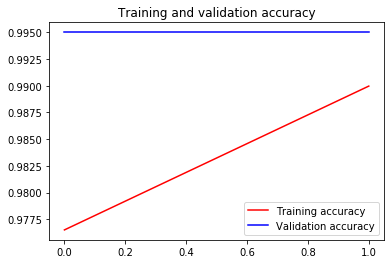

<Figure size 432x288 with 0 Axes>

In [8]:
#Display training and validation accuracy
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

Saving 3_15_1.jpg to 3_15_1 (2).jpg
[0.]
3_15_1.jpg is not a picture of Waldo...


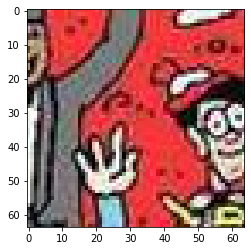

In [22]:
#Upload a new image and have the model classify it as Waldo? y/n
from google.colab import files
import numpy as np
from keras.preprocessing import image

uploaded=files.upload()

for filename in uploaded.keys():
 
  # predicting images
  path = '/content/' + filename
  img = image.load_img(path, target_size=(75, 75))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(filename + " is a picture of Waldo!")
  else:
    print(filename + " is not a picture of Waldo...")

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img = mpimg.imread(filename)
#img = matplotlib.image.imread(filename)
plt.imshow(img)



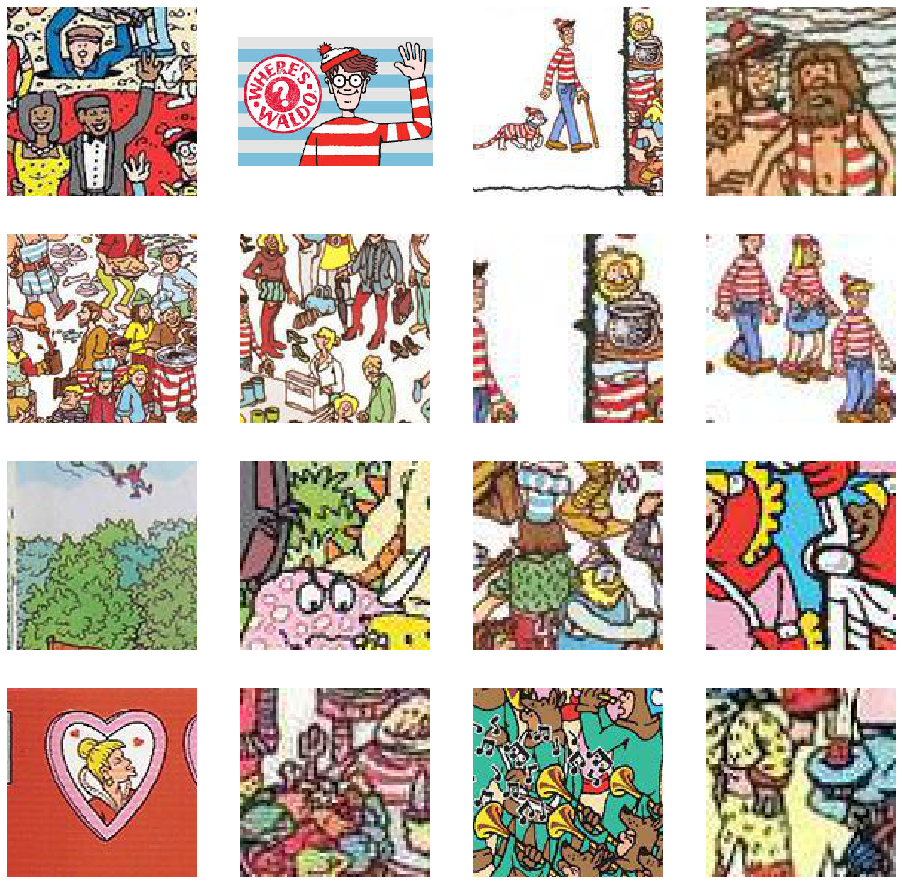

In [10]:
# Display the dataset to provide a clue to results?
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

train_waldo_fnames = os.listdir(train_waldo_dir)
train_notwaldo_fnames = os.listdir(train_notwaldo_dir)

next_waldo_picture = [os.path.join(train_waldo_dir, fname) 
                for fname in train_waldo_fnames[ pic_index-8:pic_index] 
               ]

next_notwaldo_picture = [os.path.join(train_notwaldo_dir, fname) 
                for fname in train_notwaldo_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_waldo_picture + next_notwaldo_picture):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()